In [1]:
%run setup.py

In [2]:
# mw_streams = galstreams.MWStreams(verbose=False)
plot_density_healpy.plot_pretty(figsize=(12,12))

In [3]:
def apwnorm(x, min=None, max=None):
    if min is None:
        min = np.nanmin(x[~np.isinf(x)])
    if max is None:
        max = np.nanmax(x[~np.isinf(x)])
    return np.clip((x - min) / (max - min), 0, 1)

In [119]:
# hpxcube_delve, fracdet_delve, moduli_delve = load_data.load_hpxcube('../data/2021/DELVE_iso_hpxcube_z0.0001_a12.0_gmax24_gmin16.fits.gz')
# hpxcube_bass, fracdet_bass, moduli_bass = load_data.load_hpxcube('../data/2021/BASS_DR9_iso_hpxcube_z0.0001_a12.0_gmax24_gmin16.fits.gz')
# hpxcube_decals, fracdet_decals, moduli_decals = load_data.load_hpxcube('../data/2021/DECaLS_DR9_iso_hpxcube_z0.0001_a12.0_gmax24_gmin16.fits.gz')
# hpxcube_des, fracdet_des, moduli_des = load_data.load_hpxcube('../data/2021/DES_Y6_GOLD_iso_hpxcube_z0.0001_a12.0_gmax24_gmin16.fits.gz')

In [132]:
def get_survey_data(survey, use_bkg=True, printing=False, version=0, gmax=23.):
    print('Loading %s...' %survey)
    if survey == 'DES':
        hpxcube, fracdet, modulus = load_data.load_hpxcube('../data/2021/DES_Y6_GOLD_iso_hpxcube_z0.0001_a12.0_gmax%i_gmin16.fits.gz'%gmax)
    elif survey == 'DELVE':
        hpxcube, fracdet, modulus = load_data.load_hpxcube('../data/2021/DELVE_iso_hpxcube_z0.0001_a12.0_gmax%i_gmin16.fits.gz'%gmax)
    elif survey == 'BASS':
        hpxcube, fracdet, modulus = load_data.load_hpxcube('../data/2021/BASS_DR9_iso_hpxcube_z0.0001_a12.0_gmax%i_gmin16.fits.gz'%gmax)
    elif survey == 'DECaLS':
        hpxcube, fracdet, modulus = load_data.load_hpxcube('../data/2021/DECaLS_DR9_iso_hpxcube_z0.0001_a12.0_gmax%i_gmin16.fits.gz'%gmax)
        
    ###
    
    if fracdet == None:
        fracdet = np.zeros_like(hpxcube[:, 0])
        fracdet[np.where(hpxcube[:, 0] > 0)] = 1
        
    ###

    slices = [(26, 50),
              (15, 26),
              (0, 15)]

    slice_str = '_'.join(['{}-{}'.format(x, y) for x, y in slices])
    dist = plot_density_healpy.mod2dist(modulus)
    for x, y in slices:
        print(dist[x], dist[y])

    ###

    proj = plot_density_healpy.get_ortho_proj(ends=[[5, -5], [15, -5]], half_sky=False)
    nside = hp.npix2nside(len(hpxcube[:, 0]))
    func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

    ###

    try:
        data_stack = np.load('../data/data_stack_%s_v%i_bkg%i.npy' % (survey.lower(), version, use_bkg))
#         data_stack = data_stack.T

    except:
        data_stack = []

        for i in range(np.min(slices), np.max(slices)):
            mu = modulus[i]
            if printing:
                print('%.1f' %mu)

            data_masked = plot_density_healpy.prepare_data(mu, hpxcube, modulus, None, sigma=0.2, fracmin=0.5, clip=100, sgr=True, acs=True, globs_dwarfs=True)
            data = plot_density_healpy.prepare_data(mu, hpxcube, modulus, None, sigma=0.2, fracmin=0.5, clip=100, lmc=False, milky_way=False, sgr=False,
                                                    globulars=False, dwarfs=False, galaxies=False, plane=False, bmax=25, center=False, globs_dwarfs=False, acs=False)
            if use_bkg:
                bkg = plot_density_healpy.fit_bkg(data_masked, proj, sigma=0.2)
                bkg.mask = data.mask
            else:
                bkg = 0
            data_stack.append(data - bkg)

        data_stack = np.asarray(data_stack)

        np.save('../data/data_stack_%s_v%i_bkg%i.npy' % (survey.lower(), version, bkg), data_stack.T)

    ###
    
    if data_stack.shape[1] > data_stack.shape[0]:
        data_stack = data_stack.T

    mask = streamlib.make_mask(nside=512, lmc=False, sgr=False, acs=False, globs_dwarfs=False, dwarfs=False, globulars=False, milky_way=False)
    mask |= fracdet < 1
    mask_stack = np.vstack([mask]*data_stack.shape[1]).T

    data_stack_masked = np.ma.array(data_stack, mask=mask_stack)
    data_stack_masked.fill_value = np.nan

    ###

    stacks = [np.sum(data_stack_masked[:, x:y], axis=1) / (y - x) for x, y in slices]
    for s in stacks:
        s.fill_value = np.nan

    rgb = stacks
    for i in range(3):
        X = stacks[i]
        rgb[i] = apwnorm(rgb[i], min=np.percentile(rgb[i], 1), max=np.percentile(rgb[i], 99))
        rgb[i][X == 0] = 0.

    return rgb, data_stack_masked

In [118]:
# hpxcube = np.copy(hpxcube_des)
# fracdet = np.copy(fracdet_des)
# modulus = np.copy(moduli_des)

In [117]:
# if fracdet == None:
#     # fracdet = np.ones(hpxmap.size)
#     # fracdet[hpxmap == hp.UNSEEN] = 0
#     fracdet = np.zeros_like(hpxcube[:, 0])
#     fracdet[np.where(hpxcube[:, 0] > 0)] = 1

In [7]:
# z = 0.0001
# age = 13.5
# gmax = 23.0

# # hpxcube_south, fracdet_south, modulus = load_data.load_data('DECaLS', z, age, gmax)
# # hpxcube_north, fracdet_north, modulus = load_data.load_data('BASS', z, age, gmax)

# hpxcube_delve = load_data.load_data('../data/2021/DELVE_iso_hpxcube_z0.0001_a12.0_gmax24_gmin16.fits.gz')

In [8]:
# cubes = {'bass': hpxcube_north, 'decals': hpxcube_south}
# footprints = {'bass': hpxcube_south, 'decals': fracdet_south}

In [9]:
# npix, nslice = hpxcube_south.shape
# nside = hp.npix2nside(npix)

In [116]:
# slices = [(26, 50),
#           (15, 26),
#           (0, 15)]

# slice_str = '_'.join(['{}-{}'.format(x,y) for x,y in slices])
# dist = plot_density_healpy.mod2dist(modulus)
# for x, y in slices:
#     print(dist[x], dist[y])

In [115]:
# proj = plot_density_healpy.get_ortho_proj(ends=[[5,-5],[15,-5]], half_sky=False)
# nside = hp.npix2nside(len(hpxcube[:,0]))
# func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

In [12]:
# data_stack_north = []
# data_stack_south = []

# for i in range(np.min(slices), np.max(slices)):
#     mu = modulus[i]
#     print(mu)

#     data_north_masked = plot_density_healpy.prepare_data(mu, hpxcube_north, modulus, fracdet_north, sigma=0.2, fracmin=0.5, clip=100, sgr=True, acs=True, globs_dwarfs=True)
#     data_south_masked = plot_density_healpy.prepare_data(mu, hpxcube_south, modulus, fracdet_south, sigma=0.2, fracmin=0.5, clip=100, sgr=True, acs=True, globs_dwarfs=True)

#     data_north = plot_density_healpy.prepare_data(mu, hpxcube_north, modulus, fracdet_north, sigma=0.2, fracmin=0.5, clip=100, lmc=False, milky_way=False, sgr=False, globulars=False, dwarfs=False, galaxies=False, plane=False, bmax=25, center=False, globs_dwarfs=False, acs=False)
#     data_south = plot_density_healpy.prepare_data(mu, hpxcube_south, modulus, fracdet_south, sigma=0.2, fracmin=0.5, clip=100, lmc=False, milky_way=False, sgr=False, globulars=False, dwarfs=False, galaxies=False, plane=False, bmax=25, center=False, globs_dwarfs=False, acs=False)

#     bkg_south = plot_density_healpy.fit_bkg(data_south_masked, proj, sigma=0.2)
#     bkg_south.mask = data_south.mask

#     bkg_north = plot_density_healpy.fit_bkg(data_north_masked, proj, sigma=0.2)
#     bkg_north.mask = data_north.mask
    
#     data_stack_north.append(data_north - bkg_north)
#     data_stack_south.append(data_south - bkg_south)
    
# data_stack_north = np.asarray(data_stack_north)
# data_stack_south = np.asarray(data_stack_south)

# version = 3
# np.save('../data/data_stack_north_v%i.npy' %version, data_stack_north)
# np.save('../data/data_stack_south_v%i.npy'%version, data_stack_south)

In [13]:
# data_stack_south = data_stack_south.T
# data_stack_north = data_stack_north.T
# print(data_stack_south.shape)

In [113]:
# version = 0
# use_bkg = 0
# survey = 'DES'

# try:
#     data_stack = np.load('../data/data_stack_v%i.npy' % version)
#     if data_stack.shape[1] > data_stack.shape[0]:
#         data_stack = data_stack.T

# except:
#     data_stack = []

#     for i in range(np.min(slices), np.max(slices)):
#         mu = modulus[i]
#         print('%.1f' %mu)

#         data_masked = plot_density_healpy.prepare_data(mu, hpxcube, modulus, None, sigma=0.2, fracmin=0.5, clip=100, sgr=True, acs=True, globs_dwarfs=True)
#         data = plot_density_healpy.prepare_data(mu, hpxcube, modulus, None, sigma=0.2, fracmin=0.5, clip=100, lmc=False, milky_way=False, sgr=False,
#                                                 globulars=False, dwarfs=False, galaxies=False, plane=False, bmax=25, center=False, globs_dwarfs=False, acs=False)
#         if use_bkg == True:
#             bkg = plot_density_healpy.fit_bkg(data_masked, proj, sigma=0.2)
#             bkg.mask = data.mask
#         else:
#             bkg = 0
#         data_stack.append(data - bkg)

#     data_stack = np.asarray(data_stack)
#     if data_stack.shape[1] > data_stack.shape[0]:
#         data_stack = data_stack.T

#     np.save('../data/data_stack_%s_v%i_bkg%i.npy' % (survey.lower(), version, use_bkg), data_stack)


In [114]:
# if data_stack.shape[1] > data_stack.shape[0]:
#     data_stack = data_stack.T

In [43]:
# mask_south = streamlib.make_mask(nside=512, lmc=True, sgr=False, acs=False, globs_dwarfs=False, dwarfs=True, globulars=True, milky_way=True)
# mask_south |= fracdet_south < 1

# mask_north = streamlib.make_mask(nside=512, lmc=True, sgr=False, acs=False, globs_dwarfs=False, dwarfs=True, globulars=True, milky_way=True)
# mask_north |= fracdet_north < 1

# mask_stack_south = np.vstack([mask_south]*data_stack_south.shape[1]).T
# mask_stack_north = np.vstack([mask_north]*data_stack_north.shape[1]).T

# data_stack_south_masked = np.ma.array(data_stack_south, mask=mask_stack_south)
# data_stack_north_masked = np.ma.array(data_stack_north, mask=mask_stack_north)

# data_stack_south_masked.fill_value = np.nan
# data_stack_north_masked.fill_value = np.nan

In [18]:
mask = streamlib.make_mask(nside=512, lmc=True, sgr=False, acs=False, globs_dwarfs=False, dwarfs=True, globulars=True, milky_way=True)
mask |= fracdet < 1
mask_stack = np.vstack([mask]*data_stack.shape[1]).T

data_stack_masked = np.ma.array(data_stack, mask=mask_stack)
data_stack_masked.fill_value = np.nan

In [45]:
# ###############
# # SOUTH STACK #
# ###############
# stacks = [np.sum(data_stack_south_masked[:, x:y], axis=1) / (y - x) for x, y in slices]
# for s in stacks:
#     s.fill_value = np.nan

# rgb_south = stacks
# for i in range(3):
#     X = stacks[i]
#     rgb_south[i] = apwnorm(rgb_south[i], 
# #                           min=np.percentile(rgb[i][rgb[i] != 0], 5),
# #                           max=np.percentile(rgb[i][rgb[i] != 0], 99))
#                           min=np.percentile(rgb_south[i], 1),
#                           max=np.percentile(rgb_south[i], 99))
    
#     rgb_south[i][X==0] = 0.

    
# ###############
# # NORTH STACK #
# ###############
# stacks = [np.sum(data_stack_north_masked[:, x:y], axis=1) / (y - x) for x, y in slices]
# for s in stacks:
#     s.fill_value = np.nan

# rgb_north = stacks
# for i in range(3):
#     X = stacks[i]
#     rgb_north[i] = apwnorm(rgb_north[i], 
# #                           min=np.percentile(rgb[i][rgb[i] != 0], 5),
# #                           max=np.percentile(rgb[i][rgb[i] != 0], 99))
#                           min=np.percentile(rgb_north[i], 1),
#                           max=np.percentile(rgb_north[i], 99))
    
#     rgb_north[i][X==0] = 0.
    


In [19]:
stacks = [np.sum(data_stack_masked[:, x:y], axis=1) / (y - x) for x, y in slices]
for s in stacks:
    s.fill_value = np.nan

rgb = stacks
for i in range(3):
    X = stacks[i]
    rgb[i] = apwnorm(rgb[i], 
#                           min=np.percentile(rgb[i][rgb[i] != 0], 5),
#                           max=np.percentile(rgb[i][rgb[i] != 0], 99))
                          min=np.percentile(rgb[i], 1),
                          max=np.percentile(rgb[i], 99))
    
    rgb[i][X==0] = 0.


In [20]:
from stream_helpers import rots

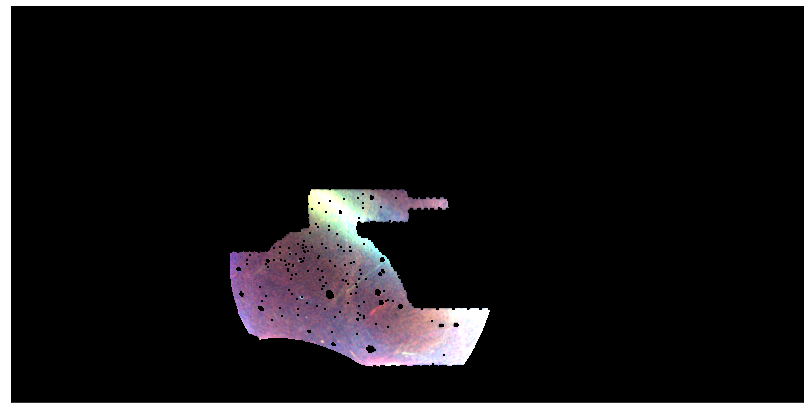

In [21]:
# rgb = rgb_south

proj = hp.projector.MollweideProj() 
# proj = hp.projector.MollweideProj(rot=rots['sag']) 
# proj = hp.projector.MollweideProj(rot=[0, 90, 0], xsize=1024)
# proj = plot_density_healpy.get_ortho_proj(ends=[[5,-5],[15,-5]], half_sky=False)
# proj = hp.projector.OrthographicProj(xsize=1024, rot=[0, 0, 0])

img = np.stack([proj.projmap(rgb[i].filled(), func) 
                for i in range(3)], axis=-1)

# img[~np.isfinite(img)] = 0

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ax.imshow(img, origin='bottom', extent=proj.get_extent())
ax.imshow(img, origin='lower', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.tight_layout()

In [52]:
# rgb = rgb_north

# # proj = hp.projector.MollweideProj(rot=rots['sag']) 
# # proj = hp.projector.MollweideProj(rot=[0, 90, 0], xsize=1024)
# proj = plot_density_healpy.get_ortho_proj(ends=[[175,70],[185,70]], half_sky=True)
# # proj = hp.projector.OrthographicProj(xsize=1024, rot=[0, 0, 0])

# func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

# img = np.stack([proj.projmap(rgb[i].filled(), func) 
#                 for i in range(3)], axis=-1)

# # img[~np.isfinite(img)] = 0

# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ax.imshow(img, origin='bottom', extent=proj.get_extent())
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
# fig.tight_layout()

In [51]:
# rgb = rgb_north

# # proj = hp.projector.MollweideProj(rot=rots['sag']) 
# # proj = hp.projector.MollweideProj(rot=[0, 90, 0], xsize=1024)
# proj = plot_density_healpy.get_ortho_proj(ends=[[175,70],[185,70]], half_sky=True)
# # proj = hp.projector.OrthographicProj(xsize=1024, rot=[0, 0, 0])

# func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

# img = np.stack([proj.projmap(rgb[i].filled(), func) 
#                 for i in range(3)], axis=-1)

# # img[~np.isfinite(img)] = 0

# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ax.imshow(img, origin='bottom', extent=proj.get_extent())
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
# fig.tight_layout()

In [50]:
# # ax = plot_density_healpy.plot_proj(proj, data_south-bkg_south, vmin=-2, vmax=2)
# # mask = streamlib.make_mask(nside=512, lmc=True, sgr=False, acs=False, globs_dwarfs=False, dwarfs=True, globulars=True, milky_way=True)
# # mask |= fracdet_south < 1
# # mask_south = mask
# # data = np.ma.array(data_stack_south[:,10], mask=mask_south)
# # data = data_stack_south_masked[:,10]
# # data = np.ma.array(data_stack_south[:,10], mask=mask_stack_south[:,10])
# proj = plot_density_healpy.get_ortho_proj(ends=[[5,-5],[15,-5]], half_sky=False)
# ax = plot_density_healpy.plot_proj(proj, data_stack_south_masked[:,10], vmin=-2, vmax=2)

In [133]:
# reload(plot_density_healpy)
# # ax = plot_density_healpy.plot_proj(proj, data_south-bkg_south, vmin=-2, vmax=2)
# # mask = streamlib.make_mask(nside=512, lmc=True, sgr=False, acs=False, globs_dwarfs=False, dwarfs=True, globulars=True, milky_way=True)
# # mask |= fracdet_south < 1
# # mask_south = mask
# # data = np.ma.array(data_stack_south[:,10], mask=mask_south)
# # data = data_stack_south_masked[:,10]
# # data = np.ma.array(data_stack_south[:,10], mask=mask_stack_south[:,10])
# proj = plot_density_healpy.get_ortho_proj(ends=[[5,-5],[15,-5]], half_sky=False)
# ax = plot_density_healpy.plot_proj(proj, data_stack_masked[:,10], vmin=-2, vmax=2)

In [134]:
# rgb, data_stack_masked = get_survey_data('DES', bkg=0)

In [135]:
version = 2
rgb_des, data_des = get_survey_data('DES', use_bkg=0, version=version, gmax=23)
rgb_delve, data_delve = get_survey_data('DELVE', use_bkg=0, version=version, gmax=23)
rgb_decals, data_decals = get_survey_data('DECaLS', use_bkg=0, version=version, gmax=23)
rgb_bass, data_bass = get_survey_data('BASS', use_bkg=0, version=version, gmax=23)

Loading DES...
Reading ../data/2021/DES_Y6_GOLD_iso_hpxcube_z0.0001_a12.0_gmax23_gmin16.fits.gz...
33.11311214825894 99.99999999999919
19.952623149688748 33.11311214825894
10.0 19.952623149688748
10.0 -5.019001817489642 -0.011244000415519807
Loading DELVE...
Reading ../data/2021/DELVE_iso_hpxcube_z0.0001_a12.0_gmax23_gmin16.fits.gz...
33.11311214825894 99.99999999999919
19.952623149688748 33.11311214825894
10.0 19.952623149688748
10.0 -5.019001817489642 -0.002851002340620654
Loading DECaLS...
Reading ../data/2021/DECaLS_DR9_iso_hpxcube_z0.0001_a12.0_gmax23_gmin16.fits.gz...
33.11311214825894 99.99999999999919
19.952623149688748 33.11311214825894
10.0 19.952623149688748
10.0 -5.019001817489642 0.0037347302606711486
Loading BASS...
Reading ../data/2021/BASS_DR9_iso_hpxcube_z0.0001_a12.0_gmax23_gmin16.fits.gz...
33.11311214825894 99.99999999999919
19.952623149688748 33.11311214825894
10.0 19.952623149688748
10.0 -5.019001817489642 -0.00972245058150401


10.0 -5.019001817489642 0.007434451641327073


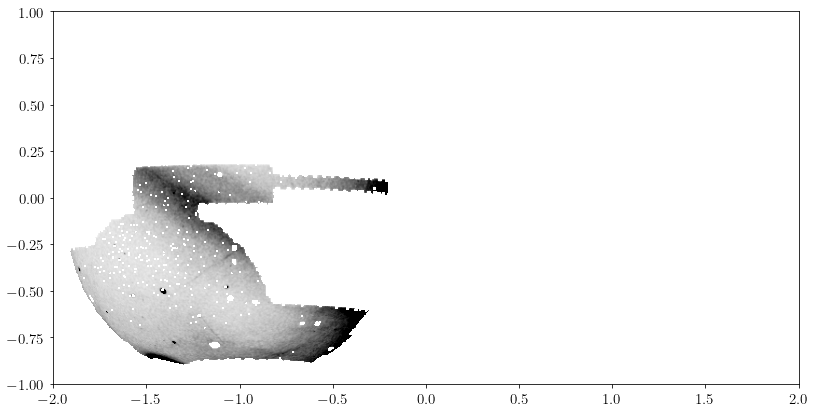

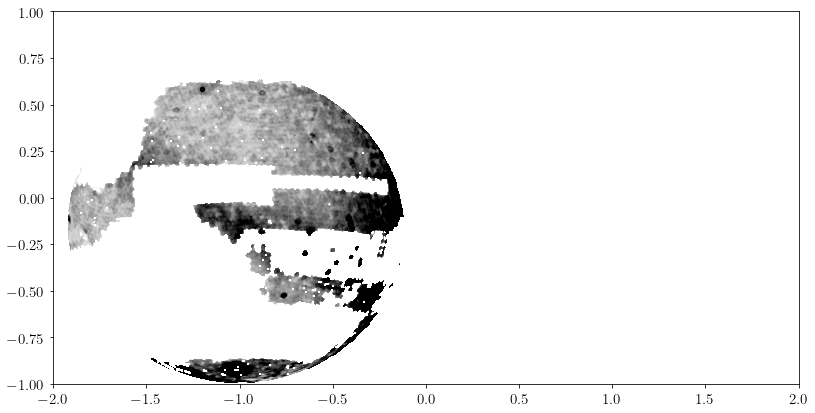

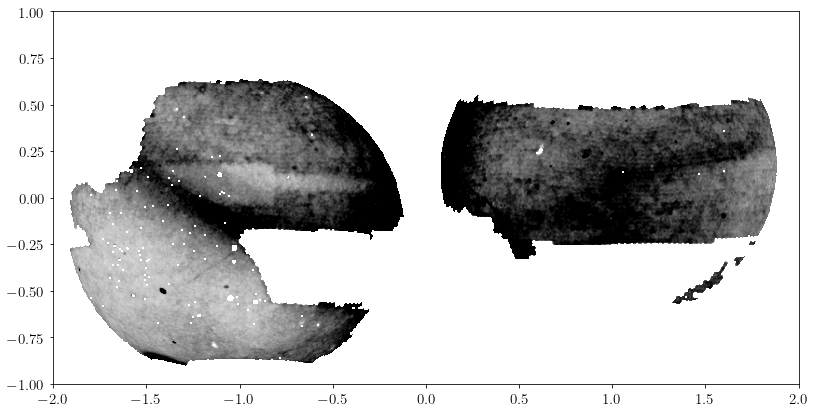

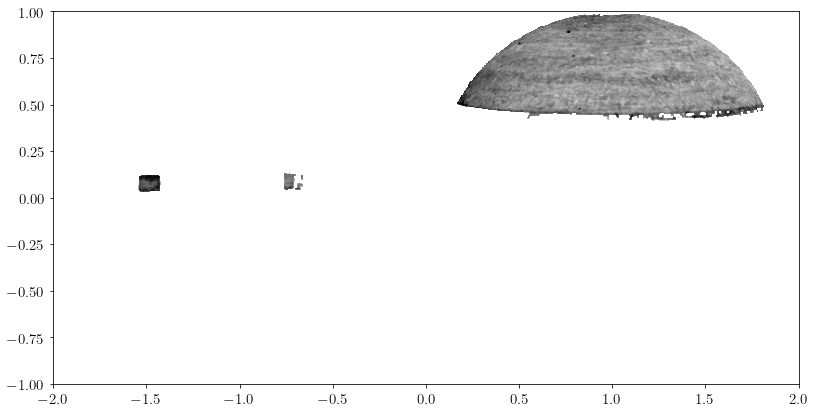

In [123]:
proj = plot_density_healpy.get_ortho_proj(ends=[[5,-5],[15,-5]], half_sky=False)
ax, im = plot_density_healpy.plot_proj(proj, data_des[:,10], vmin=0, vmax=20)
ax, im = plot_density_healpy.plot_proj(proj, data_delve[:,10], vmin=0, vmax=20)
ax, im = plot_density_healpy.plot_proj(proj, data_decals[:,10], vmin=0, vmax=20)
ax, im = plot_density_healpy.plot_proj(proj, data_bass[:,10], vmin=0, vmax=50)

In [124]:
data_merged = np.zeros_like(data_des[:,10])
data_merged[~data_bass[:,10].mask] = data_bass[:,10][~data_bass[:,10].mask]
data_merged[~data_decals[:,10].mask] = data_decals[:,10][~data_decals[:,10].mask]
data_merged[~data_delve[:,10].mask] = data_delve[:,10][~data_delve[:,10].mask] 
data_merged[~data_des[:,10].mask] = data_des[:,10][~data_des[:,10].mask] 

10.0 -5.019001817489642 0.0018319368407580282


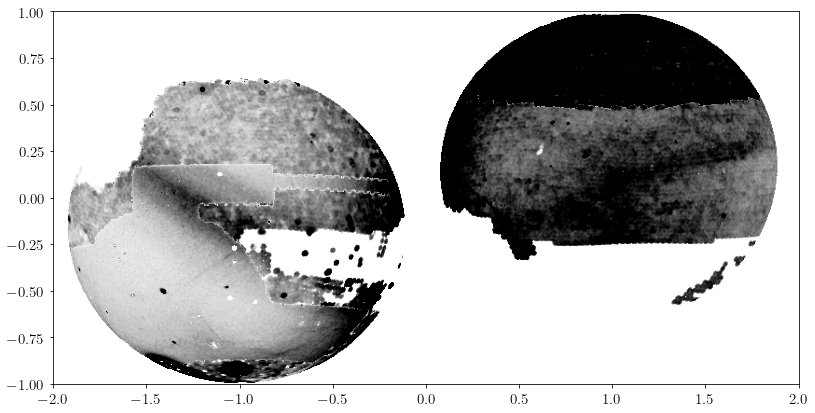

In [125]:
proj = plot_density_healpy.get_ortho_proj(ends=[[5,-5],[15,-5]], half_sky=False)
ax, im = plot_density_healpy.plot_proj(proj, np.ma.getdata(data_merged), vmin=0, vmax=20)
# ax, im = plot_density_healpy.plot_proj(proj, np.ma.getdata(data_des[:,10]), vmin=0, vmax=20)
# ax, im = plot_density_healpy.plot_proj(proj, np.ma.getdata(data_delve[:,10]), vmin=0, vmax=20, ax=ax)
# ax, im = plot_density_healpy.plot_proj(proj, data_decals[:,10], vmin=0, vmax=20, ax=ax)
# ax, im = plot_density_healpy.plot_proj(proj, data_bass[:,10], vmin=0, vmax=12, ax=ax)

10.0 5.019001817489642 0.0008987787363403779


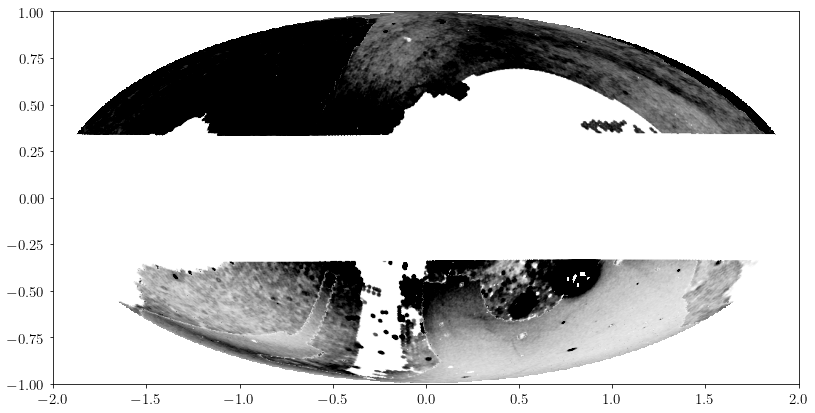

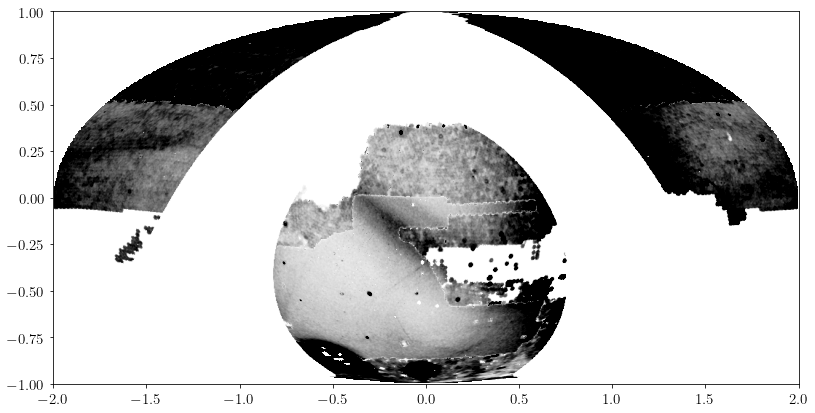

In [126]:
proj = hp.projector.MollweideProj(xsize=1024, 
                                  rot=[266.4, -28.9, 59.])
ax, im = plot_density_healpy.plot_proj(proj, np.ma.getdata(data_merged), vmin=0, vmax=20)

proj = plot_density_healpy.get_mollweide_proj(ends=[[5,5],[15,5]])
ax, im = plot_density_healpy.plot_proj(proj, np.ma.getdata(data_merged), vmin=0, vmax=20)


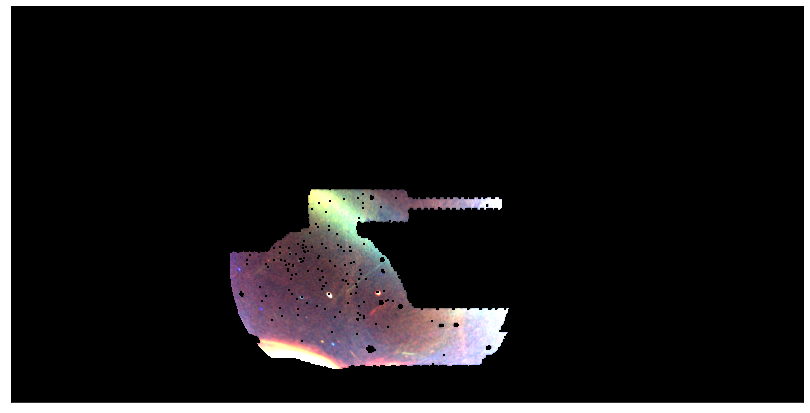

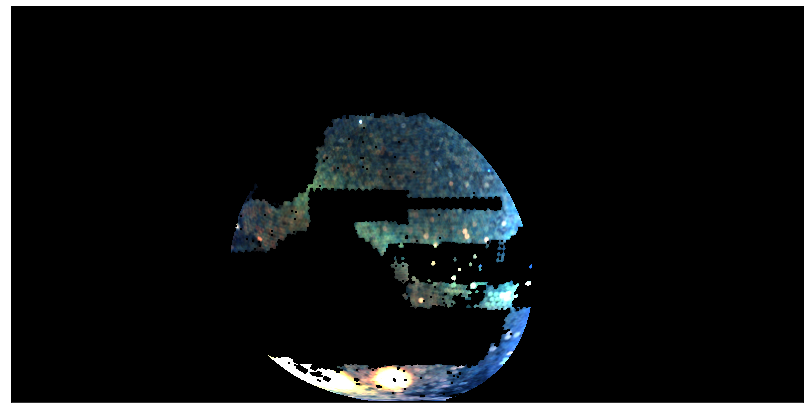

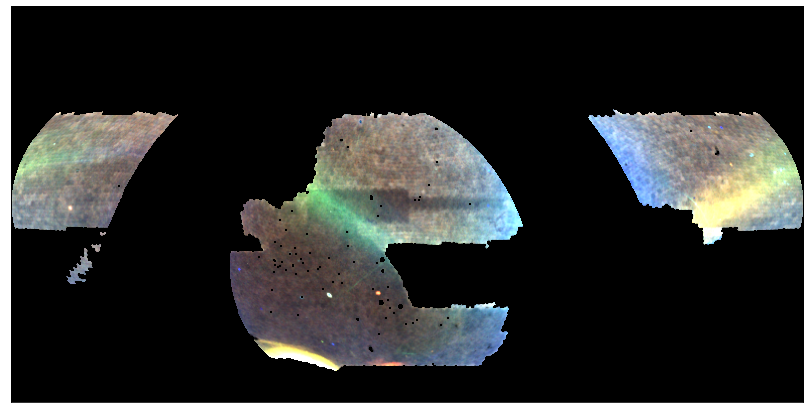

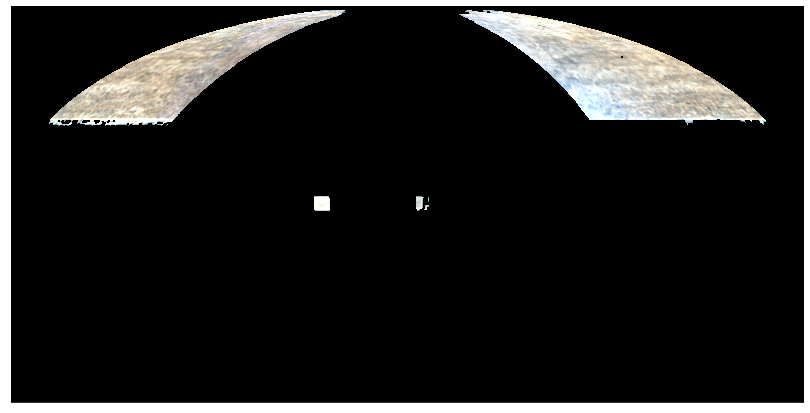

In [127]:
for rgb in [rgb_des, rgb_delve, rgb_decals, rgb_bass]:
    proj = hp.projector.MollweideProj() 
    img = np.stack([proj.projmap(rgb[i].filled(), func) 
                    for i in range(3)], axis=-1)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.imshow(img, origin='lower', extent=proj.get_extent())
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.tight_layout()

In [130]:
# STACK RGB
rgb_merged = np.ma.copy(rgb_des)
for i in range(3):
    rgb_merged[i][~data_bass[:,10].mask] = rgb_bass[i][~data_bass[:,10].mask]
    rgb_merged[i][~data_delve[:,10].mask] = rgb_delve[i][~data_delve[:,10].mask] 
    rgb_merged[i][~data_decals[:,10].mask] = rgb_decals[i][~data_decals[:,10].mask]
    rgb_merged[i][~data_des[:,10].mask] = rgb_des[i][~data_des[:,10].mask] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


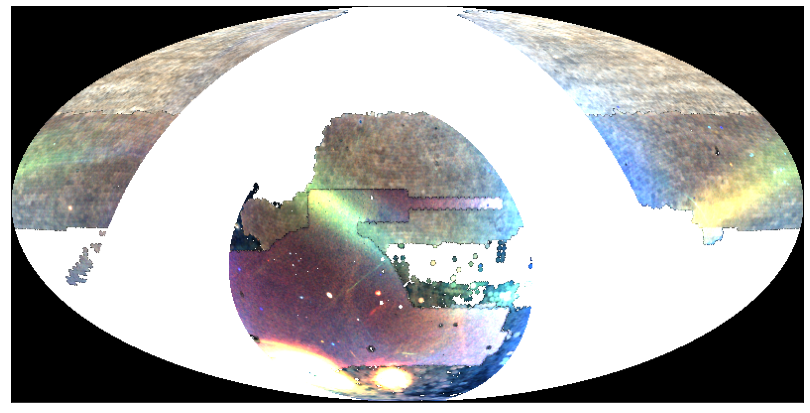

In [131]:
rgb = rgb_merged

proj = hp.projector.MollweideProj() 
# proj = hp.projector.MollweideProj(rot=rots['sag']) 
# proj = hp.projector.MollweideProj(rot=[0, 90, 0], xsize=1024)
# proj = plot_density_healpy.get_ortho_proj(ends=[[5,-5],[15,-5]], half_sky=False)
# proj = hp.projector.OrthographicProj(xsize=1024, rot=[0, 0, 0])

img = np.stack([proj.projmap(rgb[i].filled(), func) for i in range(3)], axis=-1)

# img[~np.isfinite(img)] = 0

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ax.imshow(img, origin='bottom', extent=proj.get_extent())
ax.imshow(img, origin='lower', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.tight_layout()